In [34]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});
// Enable Latex equations numbering

<IPython.core.display.Javascript object>

# Basic definitions

* [Statistical population](https://en.wikipedia.org/wiki/Statistical_population): set of similar items or events which is of interest for some question or experiment. A population is not necessarily real - it may be hypothetical or imaginary. For example, outcomes of an experiment that is carried out infinitely make a hypothetical population [[statistics.com]](https://www.statistics.com/glossary/population/) (e.g., the total number of throws that might conceivably by made in unlimited time with a particular pair of dice [[mathworld.wolfram.com]](https://mathworld.wolfram.com/Population.html))
* [Sample data](https://en.wikipedia.org/wiki/Sample_(statistics)) (equivalent definitions):
 * subset of individuals or objects collected or selected from a *statistical population*.
 * subset of the *statistical population* chosen to represent the population in a statistical analysis.
* [Statistical model](https://en.wikipedia.org/wiki/Statistical_model): mathematical model that embodies a set of assumptions concerning the *generation of sample data*. A statistical model represents the *data-generating process*.
* [Likelihood (or "Likelihood function")](https://en.wikipedia.org/wiki/Likelihood_function): measures the goodness of fit of a *statistical model* to a *sample of data* for given values of the unknown parameters.
* [Maximum Likelihood Estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) (MLE): a technique used for estimating the parameters of a given *statistical model* using some *sample data* [[2]](https://brilliant.org/wiki/maximum-likelihood-estimation-mle/), by finding the maximum value of the *likelihood function*. MLE helps us answer the question: which are the best parameters for my model given my observed data?
* [Expectation–maximization algorithm](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm): iterative method to find the *MLE* of parameters in *statistical models*, where the model depends on "latent" (unobserved or missing) [variables](https://en.wikipedia.org/wiki/Latent_variable).

# Gaussian mixture model

A [Gaussian distribution](https://en.wikipedia.org/wiki/Multivariate_normal_distribution) in $D$ dimensions is defined as:

\begin{equation}
\mathcal{N}(\mathbf{x} | \mu, \Sigma)=\frac{1}{(2 \pi)^{D / 2}|\Sigma|^{1 / 2}} \exp \left(-\frac{1}{2}(\mathbf{x}-\mu)^{T} \Sigma^{-1}(\mathbf{x}-\mu)\right)
\end{equation}

where $\mathbf{x}$ is the $D$-dimensional data vector, and $(\mu,\Sigma)$ are the mean and covariance matrix.

A [Gaussian Mixture Model](https://en.wikipedia.org/wiki/Mixture_model) (GMM) is a "*probabilistic model for representing the presence of (normally distributed) subpopulations within an overall population*". It attempts to find a mixture (combination) of multi-dimensional Gaussian probability distributions that best model an input dataset [[1]](https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html). A GMM with $K$ components (i.e., Gaussians) is defined as:

\begin{equation}
\rho_{G}=\sum_{i=1}^{K} \pi_{i} \mathcal{N}\left(\boldsymbol{\mathbf{x} | \mu}_{i}, \boldsymbol{\Sigma}_{i}\right)
\end{equation}

where $\pi_i$ are the weights (also called *mixing coefficients*) associated with each of the $K$ components. To ensure that the total probability distribution normalizes to 1, they must meet the condition:

$$\sum_{i=1}^{K} \pi_{i}=1$$

GMMs are usually employed as unsupervised clustering algorithms, presented as a [generalization of the more basic k-means algorithm](https://scikit-learn.org/stable/modules/mixture.html#gmm).


# Gaussian-uniform mixture model

The 2-dimensional Gaussian-uniform mixture model (GUMM) represents a distribution composed of a single Gaussian model mixed with a uniform (noise) model in the range $[0, 1]$. We can define the GUMM broadly as:

> A GUMM is *similar* to a 2D GMM with only two components (i.e., $K=2$): **a Gaussian and a uniform distribution**

This full model is then written as:

\begin{equation}
\rho_{GU}=\pi_{0} \mathcal{N}\left(\boldsymbol{\mathbf{x} | \mu}, \boldsymbol{\Sigma}\right) +\pi_{1} U[0,1]
\end{equation}

where $U[0,1]$ is the uniform distribution in the range $[0,1]$, and $(\pi_{0}, \pi_{1})$ are the (unknown) weights for each model. If, for example, a dataset is composed of a Gaussian with very little uniform noise, then we can expect: $\pi_{0}\approx1, \pi_{1}\approx0$.

Lets plot a distribution of points in 2 dimensions drawn from a mixture of a Gaussian and uniform noise:

N_clusters: 46
Center    : (0.53, 0.61)
Rad       : 0.10
N_field   : 652


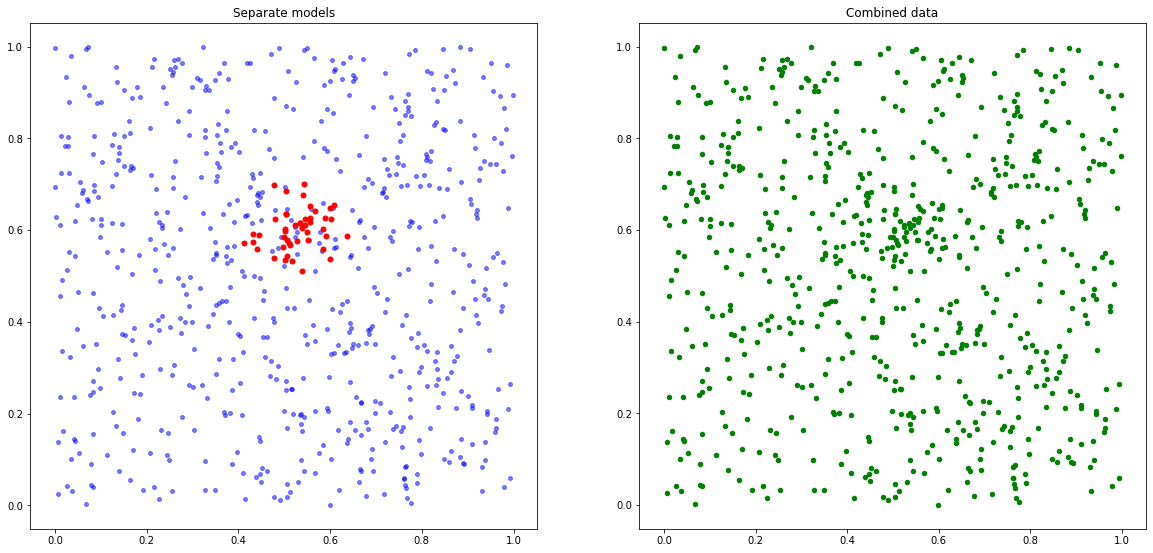

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [20, 20]
import numpy as np
from scipy.stats import multivariate_normal

def randomData():
    """
    Generate a mixture of 2D Gaussian and uniform data.
    """
    # Generate 2D Gaussian data
    N_c = np.random.randint(10, 100)
    cents = np.random.uniform(.1, .8, (2,))
    std = np.random.uniform(.02, .1)
    xy_g = np.random.normal(cents, std, (N_c, 2))

    # Generate 2D uniform noise
    N_f = np.random.randint(100, 1000)
    xy_u = np.random.uniform(.0, 1., (N_f, 2))

    print("N_clusters: {}".format(N_c))
    print("Center    : ({:.2f}, {:.2f})".format(*cents))
    print("Rad       : {:.2f}".format(2.*std))
    print("N_field   : {}".format(N_f))

    # Combine into a single data set
    data = np.concatenate([xy_g, xy_u])

    return xy_g, xy_u, data

xy_g, xy_u, data = randomData()
ax = plt.subplot(121)
ax.set_title("Separate models")
plt.scatter(*xy_u.T, c='b', s=15, alpha=.5)
plt.scatter(*xy_g.T, c='r', s=25)
ax.set_aspect('equal')
ax = plt.subplot(122)
ax.set_title("Combined data")
plt.scatter(*data.T, c='g', s=20)
ax.set_aspect('equal')

In the left plot above we know that the combined `data` array comes from a mixture of a Gaussian model (red points) and a uniform model (blue points), but in a real scenario we will work with something resembling the right plot where nothing is known a priori.


# Fitting the GUMM

In order to fit the $\rho_{GU}$ model defined in Eq. (3) to the data $\mathbf{x}$, we need to estimate the free parameters in the model. These four free parameters are: $\{\boldsymbol{\mu}, \boldsymbol{\Sigma}, \pi_0, \pi_1 \}$, where $\boldsymbol{\mu}$ (mean) is a two-dimensional vector (since we are working on a 2 dimensional space), $\boldsymbol{\Sigma}$ (covariance) is a $2\times2$ matrix, and [$\pi_0, \pi_1 \$] are scalars.

The parameters in a model (in our case, the model is the GUMM) can be estimated using MLE. 

 